### env settings

In [37]:
# turn on duplicate lib option
import os
os.environ['KMP_DUPLICATE_LIB_OK']='TRUE'

In [38]:
import torch
import torch.nn.functional as F
import torchvision
from PIL import Image
import json

device = "cuda" if torch.cuda.is_available() else "cpu"
as_numpy = lambda x: x.detach().cpu().numpy()


In [39]:
device

'cuda'

### preprocessing

In [40]:
import numpy as np
import matplotlib.pyplot as plt

# define the preprocessing transform

def get_pil_transform(): 
    transf = torchvision.transforms.Compose([
        torchvision.transforms.Resize((256, 256)),
        torchvision.transforms.CenterCrop(224)
    ])    

    return transf

def get_preprocess_transform():
    normalize = torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])     
    transf = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        normalize
    ])    

    return transf    

pill_transf = get_pil_transform()
preprocess_transform = get_preprocess_transform()

In [41]:
with open("images_with_labels/imagenet_class_index.json") as f:
    indx2label = json.load(f)
    
idx2label, cls2label, cls2idx = [], {}, {}
with open(os.path.abspath('./images_with_labels/imagenet_class_index.json'), 'r') as read_file:
    class_idx = json.load(read_file)
    idx2label = [class_idx[str(k)][1] for k in range(len(class_idx))]
    cls2label = {class_idx[str(k)][0]: class_idx[str(k)][1] for k in range(len(class_idx))}
    cls2idx = {class_idx[str(k)][0]: k for k in range(len(class_idx))}    
    


### load image

loading the image...
(375, 500, 3)


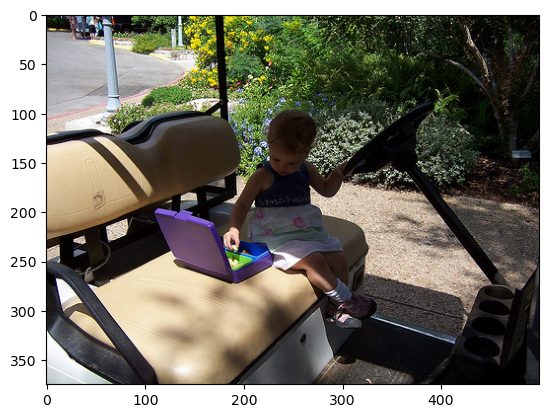

In [42]:
# load the image
print("loading the image...")
img_name = "./images_with_labels/1_n03445924_golfcart.png"
img = Image.open(img_name)
img = img.convert("RGB")

# show the image
plt.imshow(img)

# show the channel of the image
img_arr = np.array(img)
print(img_arr.shape)


In [53]:
# resize and take the center part of image to what our model expects
def get_input_transform():
    normalize = torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])       
    transf = torchvision.transforms.Compose([
        torchvision.transforms.Resize((256, 256)),
        torchvision.transforms.CenterCrop(224),
        torchvision.transforms.ToTensor(),
        normalize
    ])    

    return transf

def get_input_tensors(img):
    transf = get_input_transform()
    # unsqeeze converts single image to batch of 1
    return transf(img).unsqueeze(0)

In [56]:

x = get_input_tensors(img).to(device)


### load model

In [57]:
print("loading the model...")
### You can change the model here.
model = torchvision.models.resnet50(pretrained=True)
model.eval()
model.to(device)

loading the model...


d:\Anaconda\envs\tf\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Anaconda\envs\tf\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### add a probe

In [45]:
def decode_predictions(preds, k=5):
    # return the top k results in the predictions
    return [
        [(*indx2label[str(i)], i, pred[i]) for i in pred.argsort()[::-1][:k]]
        for pred in as_numpy(preds)
    ]

class Probe:
    def get_hook(self,):
        self.data = []
        def hook(module, input, output):
            self.data.append(output)
        return hook

def Guided_ReLU_hook(m, g_i, g_o):
    if isinstance(g_i, tuple):
        return tuple(g.clamp(min = 0) for g in g_i)
    return g_i.clamp(min = 0)

In [46]:
#add a probe to model
probe = Probe()
#probe will save the output of the layer4 during forward
handle = model.layer4.register_forward_hook(probe.get_hook())
#using guided relu for backprop
handle = [handle] + [
        m.register_backward_hook(Guided_ReLU_hook)
        for _, m in model.named_modules() if isinstance(m, torch.nn.ReLU)
        ]


### prediction

In [58]:

x = x.requires_grad_()
x.retain_grad()
logits = model(x)
# preds = logits.softmax(-1)
preds = F.softmax(logits, dim=1)


In [59]:

print("the prediction result:")
for tag, label, i, prob in decode_predictions(preds)[0]:
    print("{} {:16} {:5} {:6.2%}".format(tag, label, i, prob))

print("Calculating the saliency of the top prediction...")
target = preds.argmax().item()

the prediction result:
n03445924 golfcart           575 92.85%
n04371774 swing              843  4.18%
n02797295 barrow             428  0.50%
n04090263 rifle              764  0.40%
n04208210 shovel             792  0.25%
Calculating the saliency of the top prediction...


### Lime

In [49]:
def get_pil_transform(): 
    transf = torchvision.transforms.Compose([
        torchvision.transforms.Resize((256, 256)),
        torchvision.transforms.CenterCrop(224)
    ])    

    return transf 

pill_transf = get_pil_transform()

def batch_predict(images):
    model.eval()
    batch = torch.stack(tuple(preprocess_transform(i) for i in images), dim=0)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    batch = batch.to(device)
    
    logits = model(batch)
    probs = F.softmax(logits, dim=1)
    return probs.detach().cpu().numpy()

In [50]:
# from lime import lime_image

# explainer = lime_image.LimeImageExplainer()

In [51]:
# explanation = explainer.explain_instance(np.array(pill_transf(img)),
#                                          batch_predict,
#                                          top_labels=5,
#                                          hide_color=0,
#                                          num_samples=1000)

### Grad_Cam

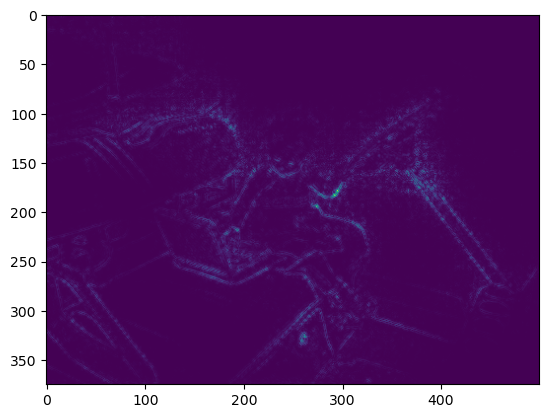

In [52]:

# get the last_conv_output
last_conv_output = probe.data[0]
last_conv_output.retain_grad() #make sure the intermediate result save its grad

#backprop
logits[0, target].backward()
for h in handle: h.remove()

grad = last_conv_output.grad 
#taking average on the H-W panel
weight = grad.mean(dim = (-1, -2), keepdim = True)
saliency = (last_conv_output * weight).sum(dim = 1, keepdim = True)
#relu
saliency = saliency.clamp(min = 0)

guided_saliency = x.grad.abs().max(dim = 1, keepdim = True).values
guided_saliency *= F.interpolate(saliency, size = guided_saliency.shape[-2:], mode = "bilinear")
plt.imshow(as_numpy(guided_saliency[0, 0]))
plt.show()